In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_chisquare
from scipy.stats import chisquare
import pickle
from bs4 import BeautifulSoup
from collections import defaultdict
import requests
from statsmodels.stats.multitest import fdrcorrection_twostage
%matplotlib inline


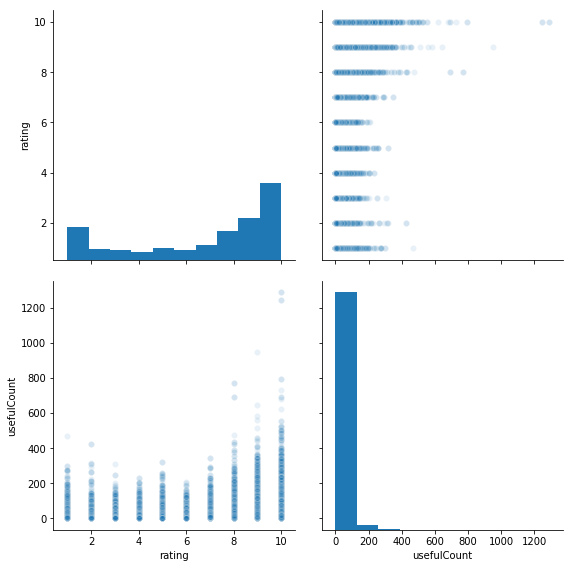

In [2]:
df = pd.read_csv('drugsCom_raw/drugsComTrain_raw.tsv',sep='\t',index_col=0)
sns.pairplot(df, plot_kws={'alpha':0.1},size=4)

In [3]:
df.shape

(161297, 6)

In [4]:
df['date'] = pd.to_datetime(df['date'])

# 1. EDA

## Total number of comments posted each day

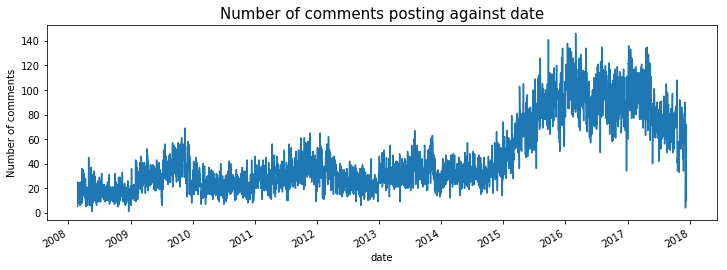

In [5]:
df.groupby('date').size().plot(figsize=(12,4))
plt.ylabel('Number of comments')
plt.title("Number of comments posting against date",fontsize=15)
plt.savefig("Plot/num_comments_date.png")

## Total number of comments posted each month

/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


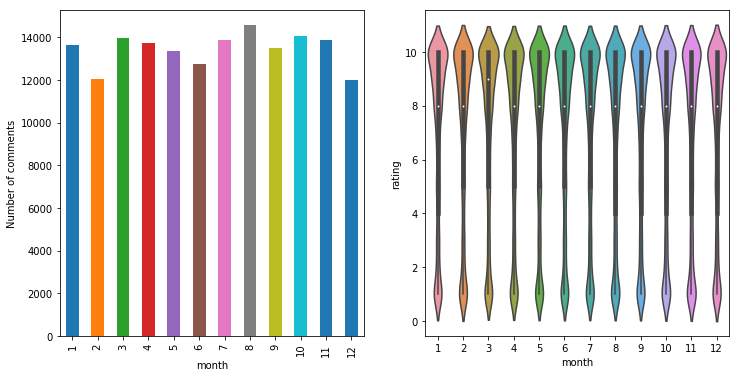

In [6]:
df['month'] = df['date'].apply(lambda x: x.month)

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
df.groupby('month').size().plot(kind='bar')
plt.ylabel('Number of comments')

plt.subplot(1, 2, 2)
sns.violinplot(data=df,x='month',y='rating')

## Total number of comments for each condition

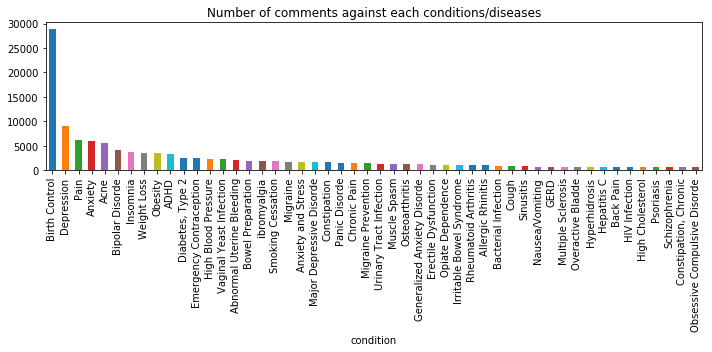

In [7]:
df_con_mon = pd.DataFrame(df.groupby(['condition','month']).size()).reset_index()

df_con_mon_pivot = df_con_mon.pivot_table(index='condition',columns='month',values=0)

plt.figure(figsize=(10,5))
df_con_mon_pivot.sum(1).sort_values(ascending=False).iloc[:50].plot(kind='bar')
plt.title("Number of comments against each conditions/diseases",fontsize=12)
plt.tight_layout()

plt.savefig("Plot/num_comments_each_condition.png")


## Total number of comments for each condition against each month

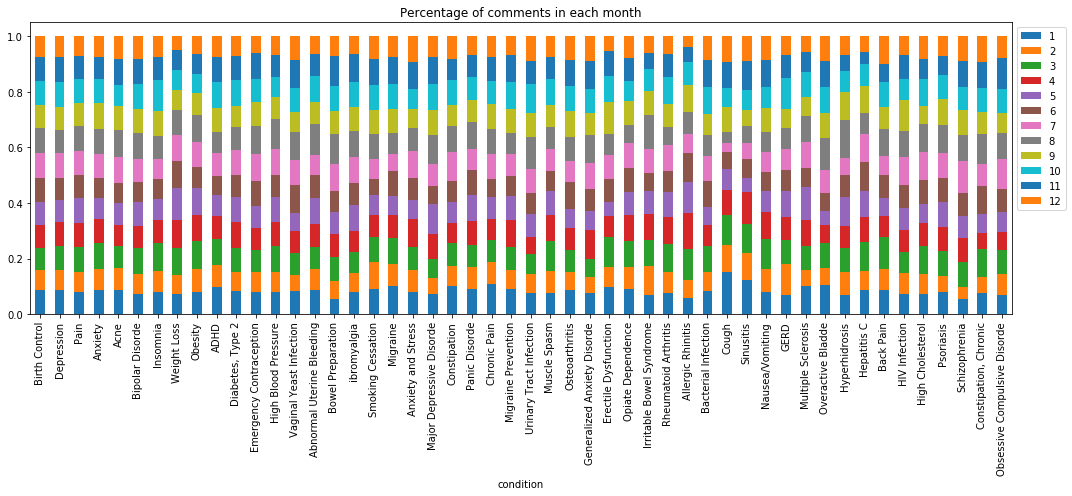

In [8]:
n = 50
top_n_index = df_con_mon_pivot.sum(1).sort_values(ascending=False).iloc[:n].index
tm_con_mon_pivot = df_con_mon_pivot.loc[top_n_index]
tm_con_mon_pivot_per = tm_con_mon_pivot.div(tm_con_mon_pivot.sum(1), axis=0)
tm_con_mon_pivot_per.plot.bar(stacked=True, figsize=(15,7))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Percentage of comments in each month")
plt.tight_layout()
plt.savefig("Plot/Per_comments_month.png")

In [9]:
## avg of comments for each condition in each month
df_con_mon_pivot_sorted = df_con_mon_pivot.loc[df_con_mon_pivot.sum(1).sort_values(ascending=False).index]

df_con_mon_pivot_sorted.sum() / len(df_con_mon_pivot_sorted)
#mon_sick_per = df_con_mon_pivot_sorted.sum()/df_con_mon_pivot_sorted.sum().sum()

month
1     15.356335
2     13.541855
3     15.686652
4     15.442308
5     15.020362
6     14.348416
7     15.580317
8     16.380090
9     15.158371
10    15.804299
11    15.606335
12    13.520362
dtype: float64

In [10]:
sum_months = df_con_mon_pivot_sorted.sum()
all_sum = sum_months.sum()

i = 0 
#df_con_mon_pivot_sorted.iloc[i,:]
expected = df_con_mon_pivot_sorted.sum(0) * (df_con_mon_pivot_sorted.iloc[i,:].sum() / all_sum)
observed = df_con_mon_pivot_sorted.iloc[i,:]
chisquare(observed,f_exp=expected)

Power_divergenceResult(statistic=38.935465364569865, pvalue=5.4327938627447377e-05)

In [11]:
sum_months = df_con_mon_pivot_sorted.sum()
all_sum = sum_months.sum()
chi_result =[]

## only take T > 5 (the cell need 5 records at least)
df_con_mon_pivot_sorted_T5 = df_con_mon_pivot_sorted[(df_con_mon_pivot_sorted > 5).all(1)]
df_con_mon_pivot_sorted_T5.head()

## compare expected and observed using chi-square test
for idx in df_con_mon_pivot_sorted_T5.index:
    ## use 
    expected = df_con_mon_pivot_sorted.sum(0) * (df_con_mon_pivot_sorted.loc[idx,:].sum() / all_sum)
    observed = df_con_mon_pivot_sorted_T5.loc[idx,:]
    
    chi_result.append([idx,chisquare(observed,f_exp=expected)])


In [12]:
df_chi = pd.DataFrame([[a[0],a[1].statistic,a[1].pvalue] for a in chi_result])
df_chi.columns = ['condition','statistic','pvalue']
df_chi['adj_pvalue'] = fdrcorrection_twostage(df_chi['pvalue'])[1]
df_chi.head()

,condition,statistic,pvalue,adj_pvalue
0,Birth Control,38.935465,0.000054,0.000293
1,Depression,19.054616,0.060120,0.083805
2,Pain,9.238257,0.599910,0.425463
3,Anxiety,20.705844,0.036550,0.056828
4,Acne,29.811602,0.001696,0.004424


In [13]:
df_chi_sorted = df_chi[df_chi['adj_pvalue'] < 0.05].sort_values('pvalue')

df_chi_sorted.head(10)

,condition,statistic,pvalue,adj_pvalue
7,Weight Loss,145.652500,1.149992e-25,9.297688e-24
35,Cough,129.962039,1.771886e-22,7.162849e-21
33,Allergic Rhinitis,89.940100,1.712822e-14,4.616054e-13
36,Sinusitis,72.581047,3.936670e-11,7.956994e-10
72,Cough and Nasal Congestion,71.094673,7.562344e-11,1.222831e-09
68,Herpes Simplex,57.745517,2.424612e-08,3.267165e-07
8,Obesity,54.759136,8.577515e-08,9.907030e-07
6,Insomnia,53.858426,1.252668e-07,1.265978e-06
53,Bronchitis,50.674949,4.731868e-07,4.250795e-06
13,Vaginal Yeast Infection,48.344293,1.239355e-06,1.002018e-05


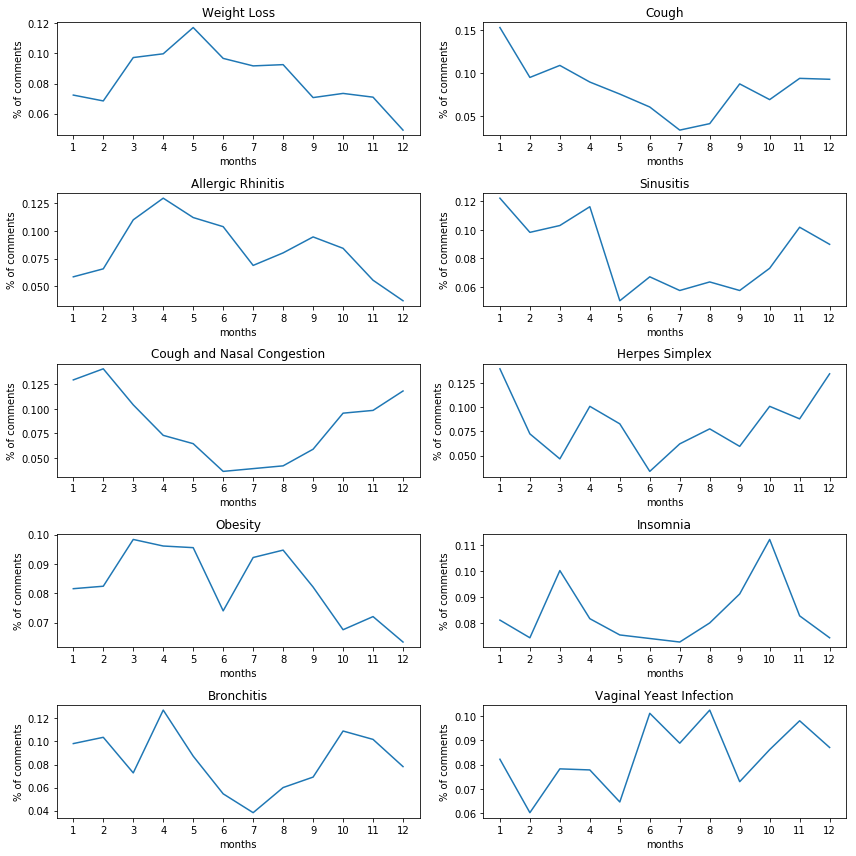

In [14]:

plt.figure(figsize=(12,12))
i =1
for idx in df_chi_sorted['condition'][:10]:
    
    each = df_con_mon_pivot_sorted_T5.loc[idx,:]/df_con_mon_pivot_sorted_T5.loc[idx,:].sum()
    
    plt.subplot(5, 2, i)
    plt.title(idx)
    plt.plot(each)
    plt.xticks(np.arange(1,13,1))
    plt.xlabel('months')
    plt.ylabel('% of comments')
    i = i +1
    
plt.tight_layout()
plt.savefig("Plot/Top_condition_signif_month.png")

# 2. NLP

## 2.1 Sentiment Analysis
### 2.1.1 intial quick predition about rating (Logistic regression)

In [15]:
## remove special symbol
def rm_sym(df):
    df['review'] = df['review'].str.replace("&#039;",'\'')
    df['review'].head()
    df['rating_cate'] = ''
    df.loc[df['rating'] >= 7,'rating_cate'] = 'high'
    df.loc[df['rating'] <= 4,'rating_cate'] = 'low'
    df.loc[(df['rating'] > 4) & (df['rating'] < 7),'rating_cate'] = 'medium'
    return df
df = rm_sym(df)

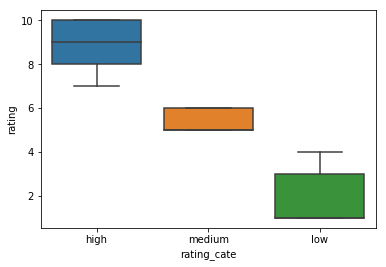

In [16]:
sns.boxplot(x=df['rating_cate'],y=df['rating'])

In [67]:
df_tem = df#.sample(80000)
df_tem.groupby('rating_cate').size() / df_tem.groupby('rating_cate').size().sum()

rating_cate
high      0.662542
low       0.248455
medium    0.089004
dtype: float64

In [68]:
!ls drugsCom_raw

drugsComTest_raw.tsv  drugsComTrain_raw.tsv


In [69]:
test = pd.read_csv("drugsCom_raw/drugsComTest_raw.tsv",sep='\t', index_col=0)
test = rm_sym(test)

In [70]:
df.shape

(161297, 8)

In [71]:
test.shape

(53766, 7)

In [72]:
import nltk
from nltk.tokenize import word_tokenize
import string
from nltk.stem.snowball import SnowballStemmer
import re
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import roc_curve, confusion_matrix


## only need to remove punctuation and stemize
stemmer = SnowballStemmer('english')

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

In [73]:
## Generate table of words with their counts
con_vec = TfidfVectorizer(stop_words='english',tokenizer=tokenize)
X_train = con_vec.fit_transform(df_tem['review'])
#target_3 = pd.get_dummies(df_tem['rating_cate'])

In [74]:
#X_train = pd.DataFrame(X_train.toarray(),columns=con_vec.get_feature_names())
y_train = df_tem['rating_cate']

In [75]:
X_test = con_vec.transform(test['review'])
#X_test = pd.DataFrame(X_test.toarray(),columns=con_vec.get_feature_names())

In [76]:
y_test = test['rating_cate']


In [77]:
print(X_train.shape)
print(X_test.shape)

(161297, 65739)
(53766, 65739)


### cross validation

In [ ]:
## n_gram -> count word 
lr = LogisticRegression(penalty='l1',multi_class='auto',solver='saga')
#lr.fit(X,target_3.iloc[:,0])

cv_score = cross_val_score(lr,X_train,y_train,scoring='accuracy',cv=3,n_jobs=-1)

In [ ]:
## TfidfVectorizer

## n = 20000, penalty='l1',multi_class='auto',solver='saga'
## array([0.75971201, 0.75446228, 0.75652565])

## n = 20000, penalty='l1',multi_class='auto',solver='saga'
## array([0.73560288, 0.73826309, 0.739985  ])

## CountVectorizer

## n = 10000, penalty='l1',multi_class='auto',solver='saga'
## array([0.70475705, 0.71251387, 0.70633158])

## n = 20000, penalty='l1',multi_class='auto',solver='saga'
## array([0.71475705, 0.72251387, 0.72633158])

### test set predition

In [78]:
lr = LogisticRegression(penalty='l1', multi_class='ovr',solver='saga',n_jobs=-1)
#y_train2 = pd.get_dummies(y_train)
lr.fit(X_train,y_train)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=None, solver='saga', tol=0.0001,
          verbose=0, warm_start=False)

In [79]:
y_test_predict = lr.predict(X_test)
#y_test2 = pd.get_dummies(y_test).values


In [80]:
from sklearn.metrics import accuracy_score, roc_auc_score 
#accuracy_score(y_test,y_test_predict)
accuracy_score(y_test,y_test_predict)

0.7810698210765168

In [81]:
# all 0.78
# 80000 0.77

In [82]:
lr_conf_mat = confusion_matrix(y_test,y_test_predict)

In [37]:
# y_test_pro = lr.predict_proba(X_test)

# ## ROC-AUC score
# lr_auc_high = roc_auc_score(y_test2[:,0],y_test_pro[0][:,1])
# lr_auc_low = roc_auc_score(y_test2[:,1],y_test_pro[1][:,1])
# lr_auc_medium = roc_auc_score(y_test2[:,2],y_test_pro[2][:,1])

# ## ROC curve parameters
# lr_roc_high = roc_curve(y_test2[:,0],y_test_pro[0][:,1])
# lr_roc_low = roc_curve(y_test2[:,1],y_test_pro[1][:,1])
# lr_roc_medium = roc_curve(y_test2[:,2],y_test_pro[2][:,1])


### importance ranking based on coefficients

In [95]:
#lr2 = LogisticRegression(penalty='l1',solver='saga')

coef_lr = pd.DataFrame(lr.coef_,columns=con_vec.get_feature_names(),index=lr.classes_)

Rating as "high": top 20 of Positive coeffients
saver        12.811616
lifesav      11.532576
miracl       11.204285
amaz          9.899080
love          9.527012
changer       8.576225
best          8.179522
miracul       7.784129
ivi           7.626480
grate         7.568605
brilliant     7.354568
save          6.938040
complaint     6.640159
excel         6.605358
bless         6.511317
drixor        6.495505
wonder        6.466753
enabl         6.410287
godsend       6.365355
happier       6.296375
Name: high, dtype: float64

Rating as "high": top 20 of Negative coeffients
disappoint   -7.874706
poison       -7.629169
wors         -7.198261
quack        -6.622652
garbag       -6.615640
ruin         -6.373322
scam         -6.200490
wast         -5.988819
trash        -5.928354
worst        -5.706473
destroy      -5.576530
peppermint   -5.547335
steer        -5.530138
useless      -5.482088
swithch      -5.270703
unhappi      -5.249898
ban          -5.209521
downhil      -5.064926
62

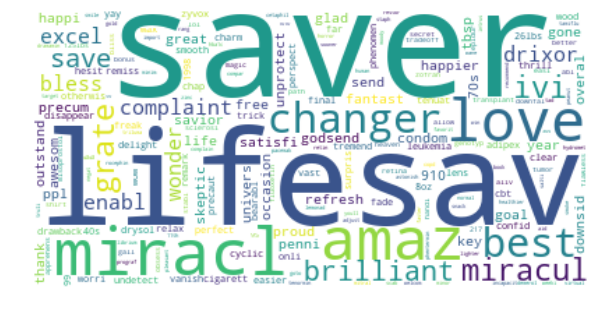

In [96]:
def top_20_pos_neg_wordcloud(category):
    print('Rating as "' + category +'": top 20 of Positive coeffients')
    print(coef_lr.loc[category].nlargest(20))

    print('\nRating as "' + category +'": top 20 of Negative coeffients')
    print(coef_lr.loc[category].nsmallest(20))

    wordcloud = WordCloud(contour_width=1,background_color='white')
    wordcloud.generate_from_frequencies(frequencies=coef_lr.loc[category])

    plt.figure(figsize=(10,8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    
top_20_pos_neg_wordcloud('high')

Rating as "medium": top 20 of Positive coeffients
quotjust         7.173871
stiffen          6.359627
62216            5.227695
30000            4.912653
tritat           4.761815
fenc             4.682780
quotment         4.674068
juri             4.506168
howev            4.387387
hinder           4.370290
quotsleepquot    4.281282
beleiv           4.223836
elat             4.159139
plummet          4.015565
periodit         3.997993
whop             3.964500
impend           3.949284
unsuccess        3.895890
hope             3.875747
21day            3.860589
Name: medium, dtype: float64

Rating as "medium": top 20 of Negative coeffients
recommend   -6.933230
miracl      -6.061870
lifesav     -5.668936
saver       -5.197767
life        -5.141718
love        -4.448573
phenergan   -4.155957
save        -4.030215
market      -4.007760
best        -3.998541
amaz        -3.954813
changer     -3.828006
disast      -3.761897
fade        -3.749392
truli       -3.626532
glad        -3.60195

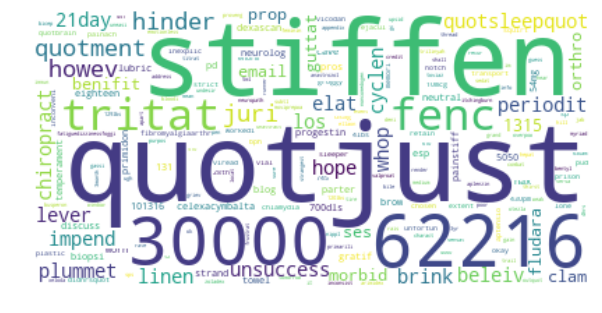

In [97]:
top_20_pos_neg_wordcloud('medium')

Rating as "low": top 20 of Positive coeffients
quack         8.777285
disappoint    8.212658
poison        7.855869
garbag        7.809575
scam          7.707168
wors          7.472201
wast          7.034341
ruin          6.552417
worst         6.284905
ban           5.926262
useless       5.905628
steer         5.237540
downhil       5.070564
worthless     5.052743
satan         5.017560
destroy       5.014585
refund        4.942168
toxic         4.843586
unhappi       4.716908
mirvaso       4.463780
Name: low, dtype: float64

Rating as "low": top 20 of Negative coeffients
saver       -13.528554
miracl      -11.198950
lifesav     -11.019360
amaz        -10.772189
love         -9.517366
complaint    -8.631599
excel        -8.388718
grate        -8.287943
best         -8.232806
wonder       -7.365489
downfal      -7.296567
ivi          -7.194983
downsid      -7.164668
awesom       -7.151466
fantast      -6.842397
great        -6.840725
save         -6.723938
bless        -6.554989
tbsp 

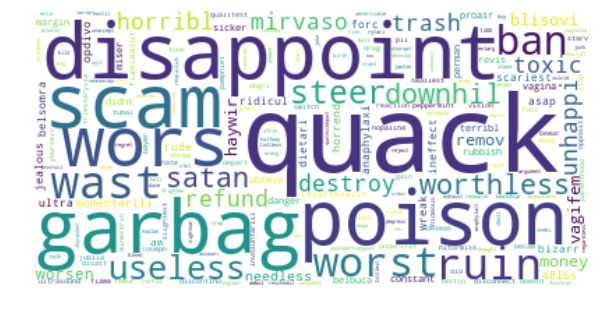

In [98]:
top_20_pos_neg_wordcloud('low')

### 2.1.2 Random forest classifier

In [57]:
from sklearn.ensemble import RandomForestClassifier

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [58]:
rfc = RandomForestClassifier(n_estimators=400,n_jobs=-1)
rfc_cv_score = cross_val_score(lr,X_train,y_train,scoring='accuracy',cv=3,n_jobs=-1)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Process ForkPoolWorker-13:
Process ForkPoolWorker-11:
Process ForkPoolWorker-12:
Process ForkPoolWorker-10:
Process ForkPoolWorker-14:
Process ForkPoolWorker-15:
Process ForkPoolWorker-7:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-6:
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    se

KeyboardInterrupt: 

In [91]:
rfc_cv_score

## n_sample = 20000, n_estimators=200
## array([0.76019796, 0.75851207, 0.75513878])

array([0.76019796, 0.75851207, 0.75513878])

In [83]:
rfc = RandomForestClassifier(n_estimators=400,n_jobs=-1)
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [84]:
y_test_rfc_predict = rfc.predict(X_test)

In [85]:
np.unique(y_test_rfc_predict)

array(['high', 'low', 'medium'], dtype=object)

In [86]:
accuracy_score(y_test,y_test_rfc_predict)

0.8875311535170926

In [87]:
# all 0.88

In [101]:
rfc_conf_mat = confusion_matrix(y_test,y_test_rfc_predict)
# rfc_conf_mat = pd.DataFrame(rfc_conf_mat,index=['Positive','Negative','Neutral'],columns=['Positive','Negative','Neutral'])
# sns.heatmap(rfc_conf_mat, annot=True,fmt="d",cmap="YlGnBu")

In [89]:
y_test.value_counts()

high      35440
low       13497
medium     4829
Name: rating_cate, dtype: int64

In [ ]:
# 0.72

### 2.1.3 Gradient boosting classifier

In [114]:
from sklearn.ensemble import GradientBoostingClassifier

# df_tem2 = df#.sample(5000)
# df_tem2.groupby('rating_cate').size() / df_tem2.groupby('rating_cate').size().sum()

# ## Generate table of words with their counts
# con_vec = TfidfVectorizer(stop_words='english',tokenizer=tokenize)
# X_train = con_vec.fit_transform(df_tem2['review'])
# #target_3 = pd.get_dummies(df_tem['rating_cate'])
# #X_train = pd.DataFrame(X_train.toarray(),columns=con_vec.get_feature_names())
# y_train = df_tem2['rating_cate']

/Users/jzz0026/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [150]:
# test = pd.read_csv("drugsCom_raw/drugsComTest_raw.tsv",sep='\t', index_col=0)
# test = rm_sym(test)
# X_test = con_vec.transform(test['review'])


In [117]:
gbc = GradientBoostingClassifier(n_estimators=300)
gbc_cv_score = cross_val_score(gbc,X_train,y_train,scoring='accuracy',cv=3,n_jobs=-1)
gbc_cv_score

array([0.71025795, 0.69946011, 0.69267707])

In [90]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=300)
gbc.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [91]:
y_test_gbc_predict = gbc.predict(X_test)
accuracy_score(y_test,y_test_gbc_predict)

0.7469032474054235

In [107]:
gbc_conf_mat = confusion_matrix(y_test,y_test_gbc_predict)
gbc_conf_mat

array([[34171,  1253,    16],
       [ 7548,  5934,    15],
       [ 3899,   877,    53]])

In [ ]:
## cv
## n_sample=20000, n_estimators=600
## ['0.73665267', '0.74066297', '0.73713428']

## n_sample=500, n_estimators=200
## array([0.70845831, 0.69886023, 0.69627851])

## test set
## n_sample=20000, n_estimators=600
## 0.7498419075252017

In [153]:
# filename = "gbc_20000_600_gbc.sav"
# infile = open(filename,'rb')
# gbc = pickle.load(infile)
# y_test_gbc_predict = gbc.predict(X_test)

### 2.1.4 SVM

In [92]:
from sklearn.svm import SVC

In [185]:
df = pd.read_csv('drugsCom_raw/drugsComTrain_raw.tsv',sep='\t',index_col=0)
df = rm_sym(test)
df_tem3 = df#.sample(40000)

test = pd.read_csv("drugsCom_raw/drugsComTest_raw.tsv",sep='\t', index_col=0)
test = rm_sym(test)

In [186]:
## Generate table of words with their counts
con_vec = TfidfVectorizer(stop_words='english',tokenizer=tokenize)
X_train = con_vec.fit_transform(df_tem3['review'])
y_train = df_tem3['rating_cate']

## test set

X_test = con_vec.transform(test['review'])
y_test = test['rating_cate']

/Users/jzz0026/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


#### rbf

In [176]:
svm_rbf = SVC(kernel='rbf')
gbc_cv_score = cross_val_score(svm_rbf,X_train,y_train,scoring='accuracy',cv=3,n_jobs=-1)
gbc_cv_score

array([0.66061788, 0.66071696, 0.66076519])

In [93]:
svm_rbf = SVC(kernel='rbf')
svm_rbf.fit(X_train,y_train)
y_test_pred_svm_rbf = svm_rbf.predict(X_test)

accuracy_score(y_test,y_test_pred_svm_rbf)

0.6591526243350817

In [103]:
svm_rbf_conf_mat = confusion_matrix(y_test,y_test_pred_svm_rbf)
svm_rbf_conf_mat

array([[35440,     0,     0],
       [13497,     0,     0],
       [ 4829,     0,     0]])

#### poly

In [175]:
svm_poly = SVC(kernel='poly')
gbc_cv_score = cross_val_score(svm_poly,X_train,y_train,scoring='accuracy',cv=3,n_jobs=-1)
gbc_cv_score

array([0.66061788, 0.66071696, 0.66076519])

In [94]:
svm_poly = SVC(kernel='poly')
svm_poly.fit(X_train,y_train)
y_test_pred_svm_poly = svm_poly.predict(X_test)

accuracy_score(y_test,y_test_pred_svm_poly)

0.6591526243350817

In [104]:
svm_poly_conf_mat = confusion_matrix(y_test,y_test_pred_svm_poly)
svm_poly_conf_mat

array([[35440,     0,     0],
       [13497,     0,     0],
       [ 4829,     0,     0]])

#### linear

In [171]:
svm_lin = SVC(kernel='linear')
svm_lin_score = cross_val_score(svm_lin,X_train,y_train,scoring='accuracy',cv=3,n_jobs=-1)
svm_lin_score

array([0.75794841, 0.76256187, 0.75213803])

In [65]:
svm_lin = SVC(kernel='linear')
svm_lin.fit(X_train,y_train)
y_test_pred_svm_lin = svm_lin.predict(X_test)

In [66]:
accuracy_score(y_test,y_test_pred_svm_lin)

0.7796190901313097

In [106]:
svm_lin_conf_mat = confusion_matrix(y_test,y_test_pred_svm_lin)
svm_lin_conf_mat

array([[32988,  2452,     0],
       [ 4570,  8925,     2],
       [ 3318,  1507,     4]])

In [ ]:
# 0.78

In [178]:
LSTM_conf_mat = np.array([[32645,  1758,  1037],
       [ 1807, 10959,   731],
       [ 1888,  1708,  1233]])

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_one(rfc_conf_mat,ax1,ax2,cbar=True):
    rfc_conf_mat_per = rfc_conf_mat/(rfc_conf_mat.sum(1).reshape(-1,1))

    rfc_conf_mat = pd.DataFrame(rfc_conf_mat,index=['Positive','Negative','Neutral'],columns=['Positive','Negative','Neutral'])
    rfc_conf_mat_per = pd.DataFrame(rfc_conf_mat_per,index=['Positive','Negative','Neutral'],columns=['Positive','Negative','Neutral'])
    
    sns.heatmap(rfc_conf_mat, annot=True,fmt="d",cmap="YlGnBu",cbar=cbar,ax=ax1)
    sns.heatmap(rfc_conf_mat_per, annot=True,fmt=".2f",cmap="YlGnBu",cbar=cbar,ax=ax2)
    #return counts#,percent]

fig, axes = plt.subplots(2, 5, figsize=(20,7))
plot_one(rfc_conf_mat,axes[0,0],axes[1,0]) #,title='Random Forest')
plot_one(LSTM_conf_mat,axes[0,1],axes[1,1])
plot_one(lr_conf_mat,axes[0,2],axes[1,2])#,title='Linear regression')
plot_one(svm_lin_conf_mat,axes[0,3],axes[1,3])#,title='SVM linear kernel')
plot_one(gbc_conf_mat,axes[0,4],axes[1,4])#,title='Gradient boosting')

axes[0,0].set_title("Random Forest",fontsize=20)
axes[0,1].set_title("LSTM",fontsize=20)
axes[0,2].set_title("Linear regression",fontsize=20)
axes[0,3].set_title("SVM linear kernel",fontsize=20)
axes[0,4].set_title("Gradient boosting",fontsize=20)
plt.text(-18.5,-0.5,"Actual",fontsize=20,rotation=90)
plt.text(-15,3,"Predicted",fontsize=20)
plt.tight_layout()
plt.savefig("Plot/Confusion_matrix_sentiment.png")
# 
# axes[1] = plot_one(lr_conf_mat)[1]

In [159]:
rfc_conf_mat/rfc_conf_mat.sum(1)

array([[9.94243792e-01, 1.48921983e-02, 6.21246635e-04],
       [1.10270880e-01, 7.10157813e-01, 8.28328847e-04],
       [5.03386005e-02, 1.08913092e-02, 6.00124249e-01]])

In [160]:
rfc_conf_mat

array([[35236,   201,     3],
       [ 3908,  9585,     4],
       [ 1784,   147,  2898]])

In [164]:
rfc_conf_mat/rfc_conf_mat.sum(1).reshape(-1,1)

array([[9.94243792e-01, 5.67155756e-03, 8.46501129e-05],
       [2.89545825e-01, 7.10157813e-01, 2.96362155e-04],
       [3.69434666e-01, 3.04410851e-02, 6.00124249e-01]])